In [17]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances

seed = 42
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 50, 500).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 51)
y_integers = y_dense[np.linspace(0, 499, 50, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵(1-50整数点)\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/10).astype(int)
group_names = [f"第{i+1}组" for i in range(5)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # 5种不同颜色
for group in range(5):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=600,
    width=900,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [18]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.0009999999999919327+0j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000-0.000000j (应>0)


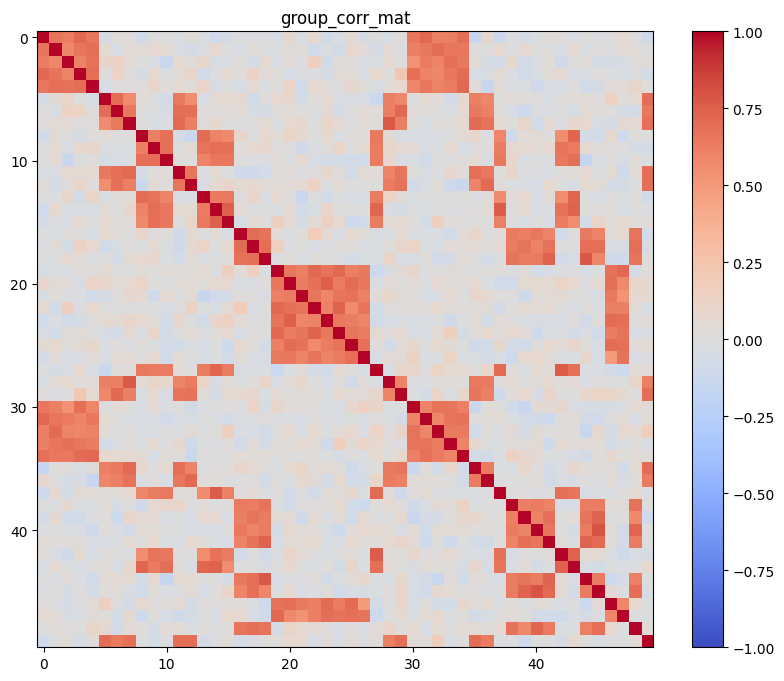

In [19]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 50
within_group_mean = 0.7
between_group_mean = 0.0
noise_std = 0.1 

np.random.seed(seed=seed)

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [20]:
# 获取大于1的值的索引
indices = np.where(corr_matrix > 1)
print("大于1的值的索引:", list(zip(indices[0], indices[1])))

# 获取大于1的具体值
values = corr_matrix[corr_matrix > 1]
print("大于1的值:", values)

大于1的值的索引: [(1, 1), (3, 3), (4, 4), (5, 5), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (18, 18), (19, 19), (20, 20), (23, 23), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (34, 34), (35, 35), (37, 37), (42, 42), (44, 44), (45, 45), (48, 48)]
大于1的值: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [21]:
group_labels+1

array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 3, 3,
       4, 4, 5, 5, 4, 2])

验证结果:
方差范围: 30.15-132.75 (目标: 25-144)
最小特征值: 0.000000 (应>0)


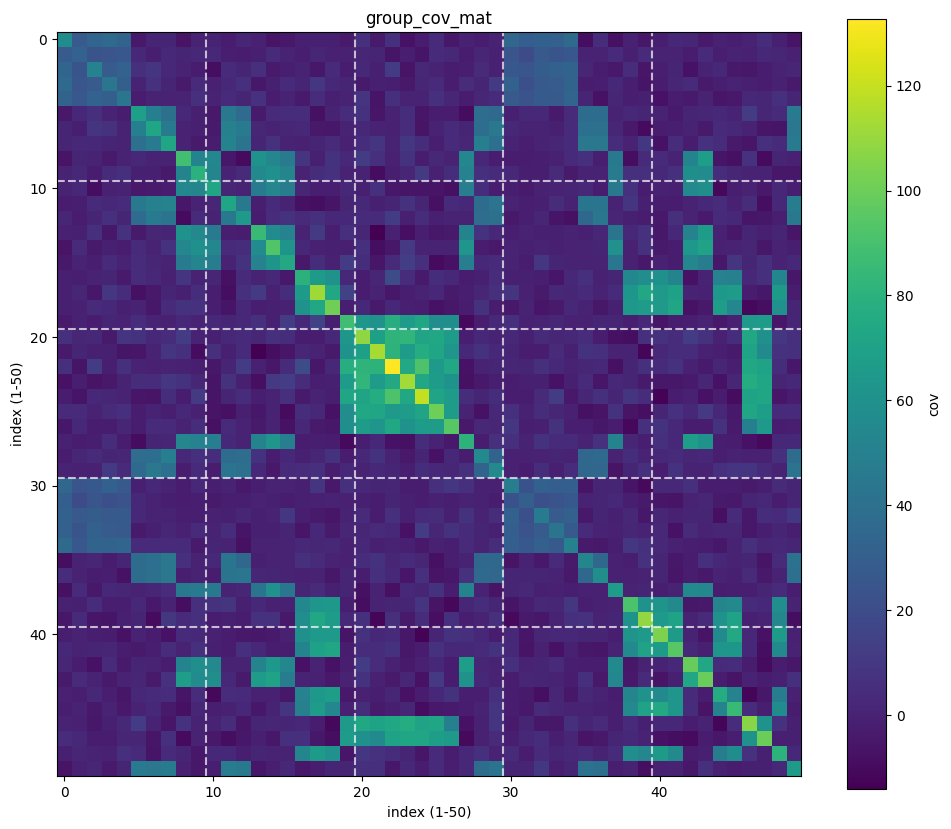

In [22]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [23]:
y_integers

array([63.7051511 , 62.91396457, 62.65616492, 62.92157366, 63.82752981,
       65.04400969, 66.5486717 , 67.76387272, 68.57966128, 68.85896796,
       68.60371763, 68.34540472, 68.16004168, 68.48787654, 69.00505559,
       69.65787739, 70.17382776, 70.58119029, 71.04352213, 71.71033177,
       72.72611334, 73.87920435, 74.9467527 , 75.2757851 , 74.8723622 ,
       73.54122635, 71.46055708, 68.97466095, 66.14577772, 64.07075826,
       62.63930816, 62.02132714, 62.00625392, 62.65606991, 63.72394375,
       65.1620072 , 66.92921038, 68.70854706, 70.16255977, 70.96394425,
       70.75807651, 70.30209937, 69.79727471, 69.67663607, 70.1146238 ,
       70.72318388, 71.23803556, 71.10119648, 70.23744623, 68.38762387])

In [24]:
variances

array([ 57.58330072,  32.10004648,  50.78115438,  43.75884253,
        43.75706863,  68.99911878,  72.11687327,  72.81645582,
        88.30779654,  79.54946354,  72.55820724,  72.49135168,
        65.36066028,  85.2565097 ,  93.09231005,  74.41500091,
        80.52487345, 112.02018719, 100.82098058,  88.01387836,
       108.28090653, 113.43983825, 132.75353687, 112.63340493,
       118.9958037 , 100.32011866,  94.65665218,  80.59483388,
        55.44600964,  55.0653271 ,  48.06708428,  30.15313277,
        46.72272799,  42.17665019,  50.314493  ,  52.98154302,
        58.70183732,  67.37608557,  91.37029903, 108.986684  ,
       103.53904792,  94.82611834,  98.45216551,  99.16350943,
        76.99248565,  85.2954385 , 106.79609537,  99.70100705,
        81.00125651,  66.05621871])